In [1]:
import os
import sys

# print(os.getcwd())
# add os.path.join(os.getcwd(), 'dev') to sys.path
sys.path.append(os.path.join(os.getcwd(), "dev"))
import h5py
from geom_2d_plot import (plot_new_ppdf_mpl, plot_polygons_from_vertices_mpl,
                          plot_scanner_from_vertices_2d_mpl)
from matplotlib import pyplot as plt
from torch import tensor

In [2]:
def load_scanner_layouts(filename: str):
    from torch import load as torch_load
    import os

    if not os.path.exists(filename):
        print(f"File {filename} does not exist.")
        raise FileNotFoundError(f"File {filename} does not exist.")
    filename_unique_id = filename.split(".")[0].split("_")[-1]
    scanner_layouts_data = torch_load(filename, weights_only=True)["layouts"]
    return scanner_layouts_data, filename_unique_id


def load_scanner_layout_geometries(layout_idx: int, scanner_layouts_data):
    # Load the scanner geometry
    plates_vertices = scanner_layouts_data[f"position {layout_idx:03d}"][
        "plate segments"
    ].to("cpu")
    detector_units_vertices = scanner_layouts_data[f"position {layout_idx:03d}"][
        "detector units"
    ].to("cpu")
    return plates_vertices, detector_units_vertices

In [3]:
scanner_layouts_dir = "scanner_layouts"
scanner_layouts_filename = "scanner_layouts_77faff53af5863ca146878c7c496c75e.tensor"

scanner_layouts, filename_unique_id = load_scanner_layouts(
    os.path.join(scanner_layouts_dir, scanner_layouts_filename)
)
plates_vertices, detector_units_vertices = load_scanner_layout_geometries(
    0, scanner_layouts
)  # Load the first layout (index 0)

fov_dict = {
    "n pixels": tensor([512, 512]),
    "mm per pixel": tensor([0.25, 0.25]),
    "center coordinates in mm": tensor([0.0, 0.0]),
}
fov_dict["size in mm"] = fov_dict["n pixels"] * fov_dict["mm per pixel"]


ppdfs_dataset_dir = "../../data/scanner_layouts_77faff53af5863ca146878c7c496c75e"
ppdfs_hdf5_filename = "position_000_ppdfs.hdf5"

with h5py.File(
    os.path.join(ppdfs_dataset_dir, ppdfs_hdf5_filename), "r"
) as f:
    # Print the names of all datasets in the file
    # print("Datasets in the file:")
    #  for name in f:
    #      print(name)
    ppdfs = f["ppdfs"][:]
    ppdfs = tensor(ppdfs)
    # ppdfs = ppdfs.permute(2, 0, 1)  # Change the order of dimensions to (n_angles, n_pixels, n_pixels)


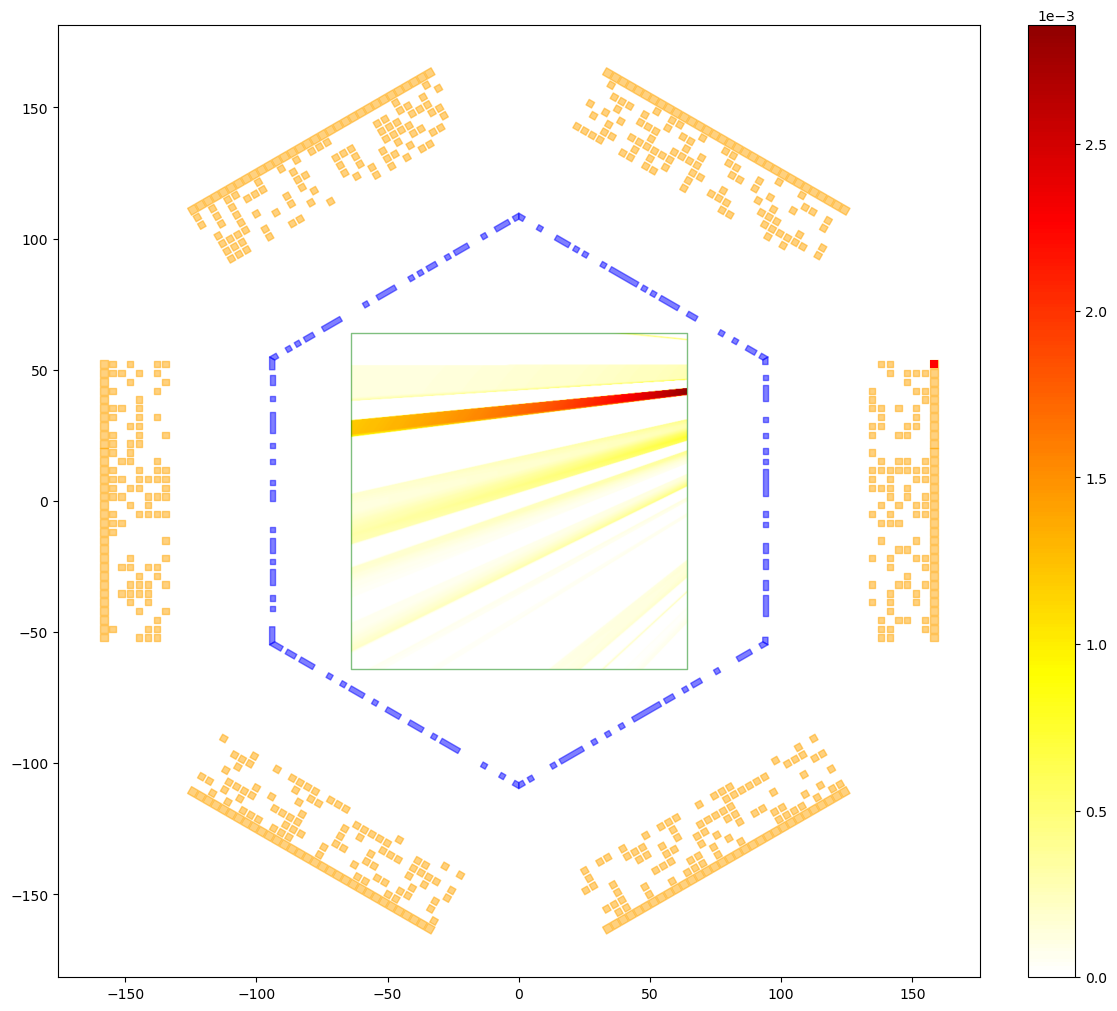

In [5]:
selected_detector_unit_idx = 120

fig, ax = plt.subplots(figsize=(11, 10), layout="constrained")

# print(ppdfs.shape,"512 x 512 =", 512 * 512)
# Plot the ppdfs
plot_new_ppdf_mpl(
    ppdfs[selected_detector_unit_idx].reshape(512, 512),
    ax=ax,
    fov_dict=fov_dict,
)

# Plot the scanner layout
scanner_polygon_collection_dict = plot_scanner_from_vertices_2d_mpl(
    plates_vertices,
    detector_units_vertices,
    ax=ax,
    fov_dict=fov_dict,
)

# plot the selected detector unit
selected_detector_unit_polygon_collection = plot_polygons_from_vertices_mpl(
    detector_units_vertices[selected_detector_unit_idx].unsqueeze(0),
    ax=ax,
    fc="red",
    ec="none",
)